In [907]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np

# A look at Hamilton County Abatements on Single Family Properties
## By Bryan Corder
The data for this notebook can be found on the Auditor's website (downloaded on 9/16/2020), here: https://www.hamiltoncountyauditor.org/downloads.asp
It was geocoded using Geopy before being imported into this notebook.

In [908]:
#Load the Abatement File
currentabatement = pd.read_csv('CurrentAbatements.csv')
#Load the land use dictionary
landuse = pd.read_csv('land_use_dict.csv')
landuse.head(5)

,CATEGORY,DESCRIPTION,DEPARTMENT OF TAX EQUALIZATION,HAMILTON COUNTY
0,AGRICULTURAL,VACANT LAND,100.0,100
1,AGRICULTURAL,CASH - GRAIN OR GENERAL FARM,101.0,101
2,AGRICULTURAL,LIVESTOCK FARM EXCEPT DAIRY & POULTRY,102.0,102
3,AGRICULTURAL,DAIRY FARMS,103.0,103
4,AGRICULTURAL,POULTRY FARMS,104.0,104


There are different kinds of property uses as can be seen in the dictionary above. The focus of this little study will be on Single Family properties, which is property code 510. Anyone planning on doing more than 2,500 of work that will increase the value of their property can pay the application fee of 250 and apply for an abatement. Once the work is verified by City employees in DCED, the abatement is passed on to the Auditor for assessment. Because an abatement is a lock on the base price of the property prior to improvements for tax purposes, the value of an abatement fluctuates as the value of a property changes in value during the term of the abatement. For example, a property with a "locked" value of 200,000 and current value of 300,000 will have an abatement value of 100,000. If that property is sold for 250,000, the Auditor will update the value of the property to 250,000 while maintaining the "locked" value of 200,000 and the abatement value will decrease from 100,000 to 50,000. Regardless of the abatement value, the homeowner will only pay taxes on the "locked" value until the term of the abatement is over and the property is taxed at full value. This is different from Tax Increment Financing (TIF) district where the full value of the property is taxed, but a portion of the taxes are diverted to a neighborhood fund rather than going to the county and apportioned as levies dictate. 

For all applicable City Ordinances and limits on abatements, please refer to this FAQ: https://www.cincinnati-oh.gov/planning/assets/File/51393.pdf

In [909]:
#Create a dictionary for land use codes
description = landuse.DESCRIPTION.tolist()
codes = landuse['HAMILTON COUNTY'].tolist()
res = {codes[i]: description[i] for i in range(len(description))} 

#Map the values onto the abatement dataframe
currentabatement['land use english'] = currentabatement['land use'].map(res)

As you can see from the chart below, Single Family is the most common type of abatement followed by Condominiums. The value of commercial abatements can be for hundreds of millions of dollars, so they cannot be handled in the same analysis of residential abatements. 

In [910]:
#See how many of each type of abatement there is
currentabatement['land use english'].value_counts()

SINGLE FAMILY                                2975
CONDOMINIUMS                                 1328
P.U.D. (LANDOMINIUM)                          128
VACANT LAND                                    93
CONDOMINIUM OFFICE BUILDING                    70
TWO FAMILY DWELLINGS                           66
APARTMENTS - 40+ UNITS                         43
RETAIL - APARTMENTS OVER                       35
THREE FAMILY DWELLINGS                         35
APARTMENTS - 4 TO 19 UNITS                     30
WAREHOUSE                                      26
OFFICE, ELEVATOR (3 STORIES PLUS)              23
LOW INCOME HOUSE TAX CREDIT(commercial)        23
LIGHT MANUFACTURING                            20
PARKING GARAGES / LOTS                         13
OFFICE BUILDINGS                               13
OTHER STRUCTURES                               12
APARTMENTS - 20 TO 39 UNITS                    11
SMALL DETACHED RETAIL (10,000)                 11
LOW INCOME HOUSE TAX CREDIT (residential)       9


In [911]:
# Get the total abatement value by each land use category
aggregates = currentabatement[['land use', 'land use english', 'abatement_value']]
aggregates = aggregates.groupby(['land use', 'land use english'])['abatement_value'].sum()
aggregates.head(50)

land use  land use english                        
199       OTHER - CAUV                                     5000
300       VACANT LAND                                   2392130
310       FOOD/DRINK PROCESSING                        14303440
330       MEDIUM MANUFACTURING                         18525720
340       LIGHT MANUFACTURING                          50254380
350       WAREHOUSE                                    33355690
351       WAREHOUSE/MULTI-TENANT                        7789900
360       TRUCK TERMINAL                                 329220
370       SMALL SHOP                                     795110
399       OTHER                                         4634090
400       VACANT LAND                                   1915730
401       APARTMENTS - 4 TO 19 UNITS                   22018250
402       APARTMENTS - 20 TO 39 UNITS                  20101730
403       APARTMENTS - 40+ UNITS                      494785130
404       RETAIL - APARTMENTS OVER                   

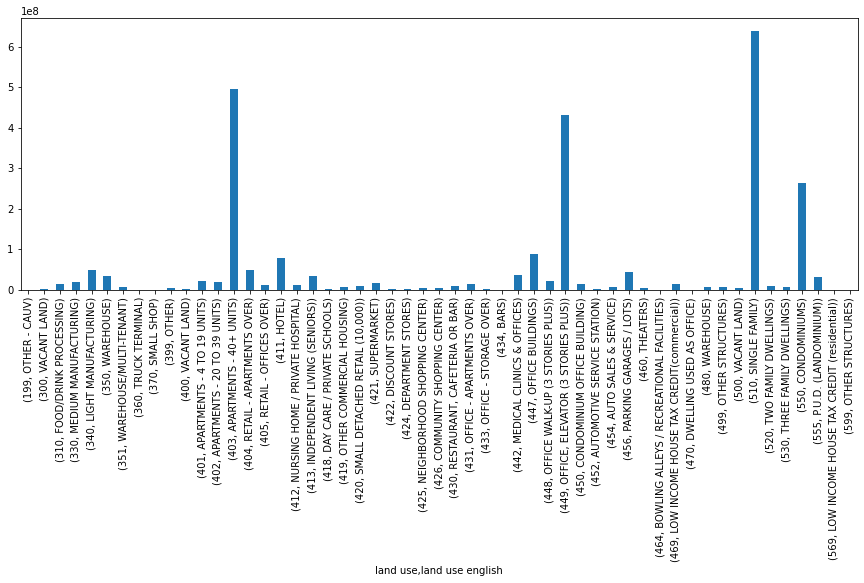

In [912]:
# Plot them
ax = aggregates.plot.bar(x='land use', y='abatement_value', figsize=(15,5))

In [913]:
#Filter all of the single family properties out of the list
single_family = currentabatement[currentabatement['land use'] == 510].reset_index()
#Check how many failed to geocode
fails = single_family.latitude.isnull().sum()
#out of how many total
total = len(single_family)
#completion rate
rate = 100 - round((fails / total), 4) * 100
print('Currently Geocoded: {}%'.format(rate))

Currently Geocoded: 93.98%


In [914]:
# indexval = single_family.abatement_value.idxmax(axis=0, skipna=True)
# print(indexval)
# print(single_family.iloc[indexval])

In [915]:
# indexval = single_family.abatement_value.idxmin(axis=0, skipna=True)
# print(indexval)
# print(single_family.iloc[indexval])

This notebook is a work in progress.

In [916]:
#Get the range of abatements
x, y = single_family.abatement_value.min(), single_family.abatement_value.max()
mean = single_family.abatement_value.mean()
median = single_family.abatement_value.median()
print("Range is ${}-${}\nAverage Abatement is ${}\nMedian Abatement is ${}".format(x,y,mean,median))

Range is $140-$1751170
Average Abatement is $214599.89613445377
Median Abatement is $172190.0


Looking only at Single Family abatements, the range of abatement values is 140 dollars (remember, abatement values fluctuate) and 1,751,170 dollars. The average value of the abatements is 215,600 dollars and the median is 172,190 dollars showing there are definitely some properties that have benefited a lot more than others and are outliers. The histogram below maps out the distribution.

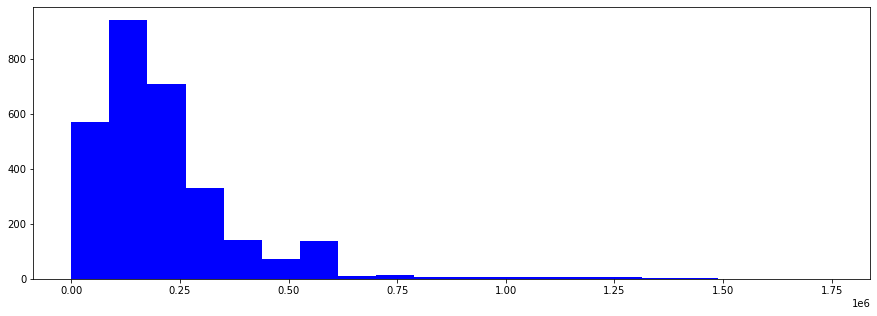

In [917]:
#Plot their distribution
num_bins = 20
plt.figure(figsize=(15,5))
n, bins, patches = plt.hist(single_family.abatement_value, num_bins, facecolor='blue')
plt.show()

In [918]:
#Drop all of the properties that failed to geocode
single_family = single_family.dropna(axis=0, subset=['latitude', 'longitude'])
#See how many single family abatements there are in the dataframe
len(single_family)

2796

As this is still a work in progress, I am replicating the above removing the properties that failed to geocode in the geocoder and haven't been manually updated.

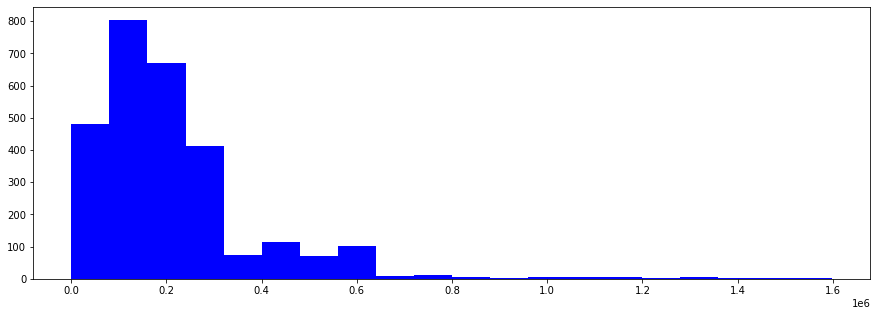

In [919]:
#Plot their distribution
plt.figure(figsize=(15,5))
n, bins, patches = plt.hist(single_family.abatement_value, num_bins, facecolor='blue')
plt.show()

Since we are doing a heatmap and we don't want the few outliers to be red and everything else to be blue (except when aggregated with zoom), for visualization purposes, I'm going to remove outlier properties to give a more accurate representation of the distribution of abatement value in the county.

In [920]:
#Remove outliers for better mapping
single_family['z_scores'] = np.abs(stats.zscore(single_family.abatement_value))
single_family = single_family[single_family.z_scores < 3]


In [921]:
#Normalize the abatement value to a value between 0 and 1
single_family['abatement_normal']=(single_family.abatement_value-x)/(y-x)

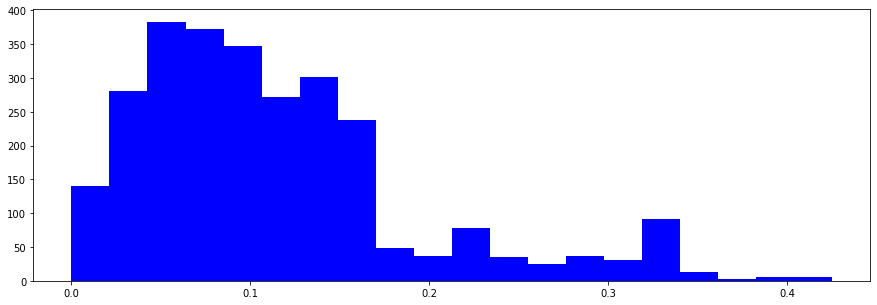

In [922]:
#Plot their distribution
plt.figure(figsize=(15,5))
n, bins, patches = plt.hist(single_family.abatement_normal, num_bins, facecolor='blue')
plt.show()

In [923]:
#Establish the map
map1 = folium.Map(
    location=[39.1255405,-84.476745],
    tiles='cartodbpositron',
    zoom_start=12,
)
#Iterate over the dataset and create coordinates and weight [latitude, longitude, normalized abatement value]
data = []
for x in range(len(single_family)):
    data.append([single_family.latitude.iloc[x], single_family.longitude.iloc[x], single_family.abatement_normal.iloc[x]])

#Apply the data and set the radius/blur of the heatmap    
HeatMap(data, radius=6, blur=5,).add_to(map1)
#Display the map
map1